# Tracking the Experiment
This code is a basic illustration of how one can utilize TensorBoard with PyTorch for monitoring the training process. TensorBoard is a visualization tool provided with TensorFlow, but it can also be used with PyTorch through the torch.utils.tensorboard module. Here's a step-by-step breakdown of the code:

1. Imports:
torch: PyTorch's main module.
SummaryWriter: This is the interface used to log various types of information, which can then be visualized using TensorBoard.
2. Create a dummy model and optimizer:
A simple linear regression model (torch.nn.Linear) is defined with an input size of 10 and an output size of 1.
An optimizer (torch.optim.SGD) is instantiated to optimize the model's parameters using Stochastic Gradient Descent.
3. Instantiate SummaryWriter:
writer = SummaryWriter(): This initializes an instance of SummaryWriter. By default, it will save logs to the runs/ directory. These logs can later be visualized using TensorBoard.
4. Training loop:
The loop runs for 100 epochs.
For each epoch:
  * The optimizer's gradients are zeroed out using optimizer.zero_grad (). This is a standard step in PyTorch since gradients accumulate by default.
 * A forward pass is made with a batch of random data of size (32, 10).
  * A dummy loss is computed. It's the mean squared error between the model's output and another batch of random data. This represents a mock training scenario.
  * The loss is backpropagated using loss.backward().
  * The optimizer updates the model's parameters with optimizer.step().
5. Log the loss to TensorBoard:
  * For each epoch, the training loss is logged to TensorBoard using writer.add_scalar(). The first argument is the tag (a string to identify the scalar), the second is the scalar value, and the third is the x-coordinate (typically the epoch or iteration number).
6. Close the writer:
  * After logging everything, it's a good practice to close the writer using writer.close(). This ensures all data is flushed out and no resources are wasted.
To visualize the data in TensorBoard after running this script, you'd typically open a terminal and run:

7. Run the following command on terminal

```tensorboard --logdir=runs```
8. Then, open a browser and navigate to the provided URL (usually http://localhost:6006). There, you would see a plot of the "Training loss" over the 100 epochs.

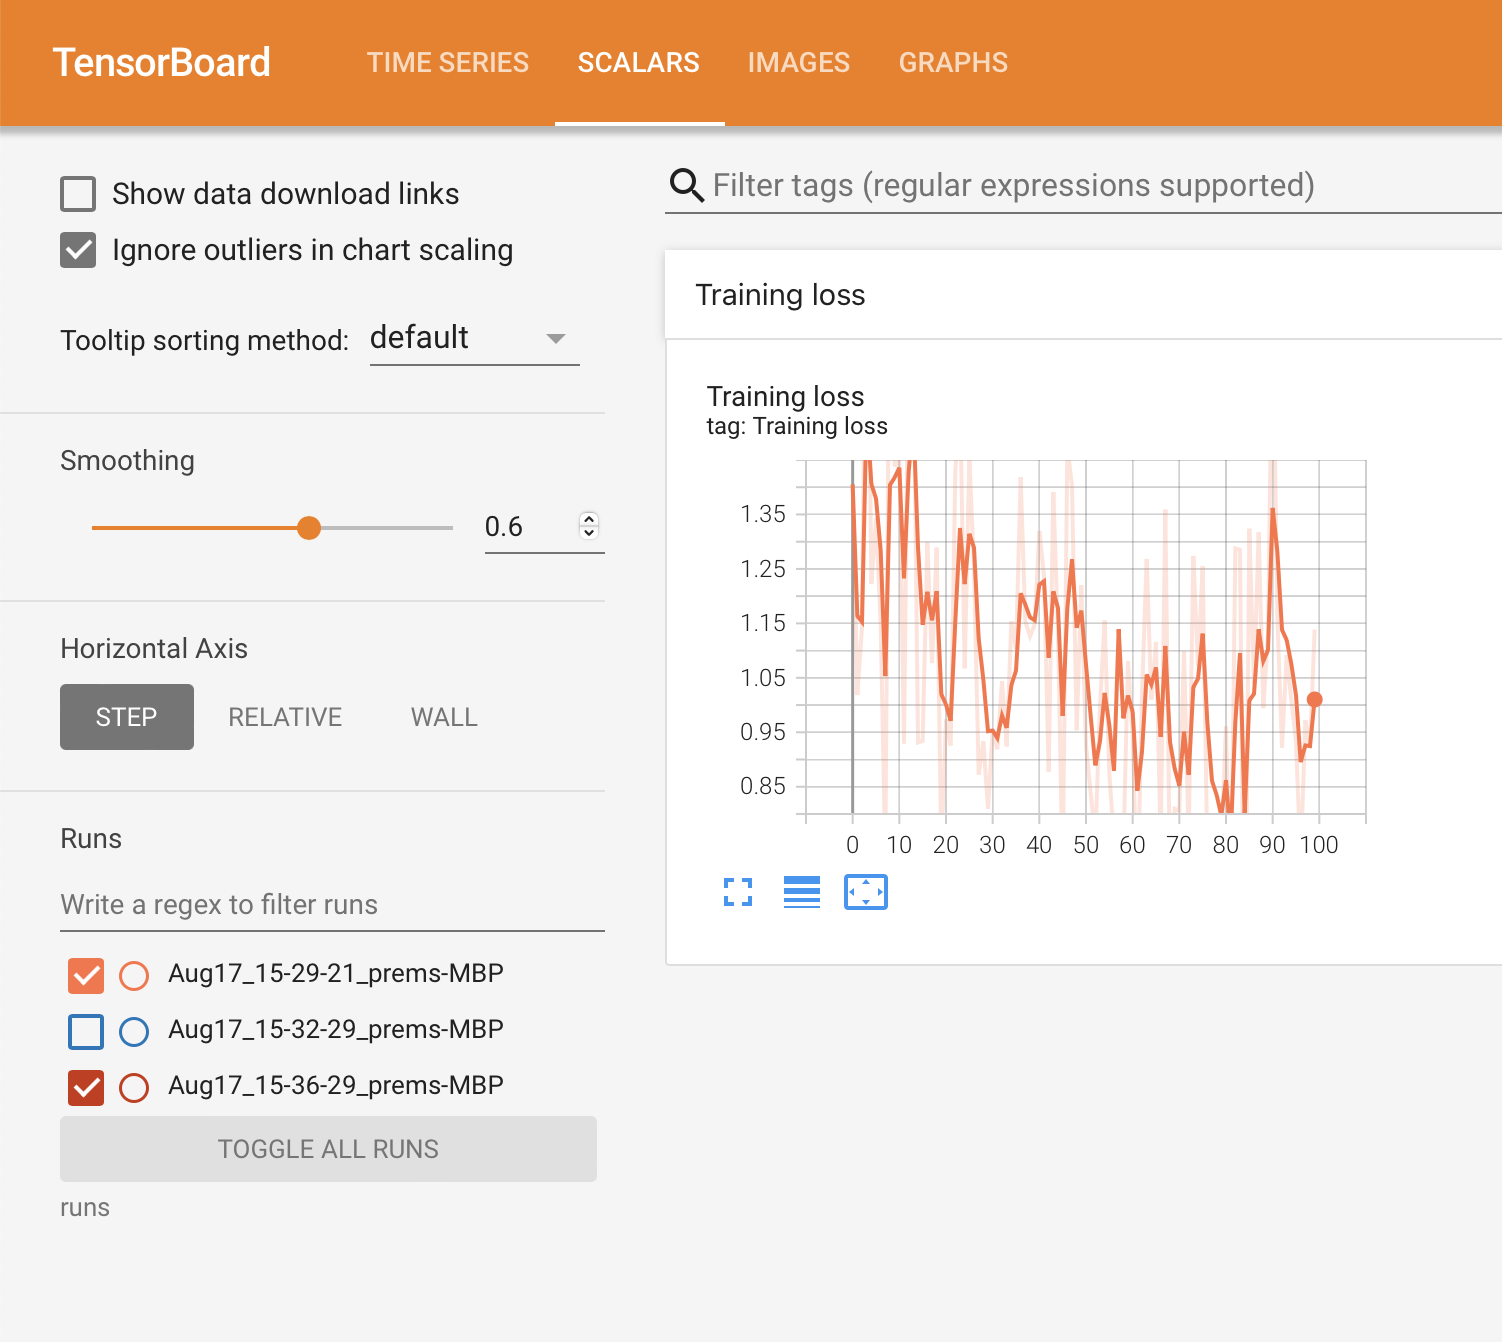

In [ ]:
# 런타임 30초 소요
import torch
from torch.utils.tensorboard import SummaryWriter

# 더미 모델 및 옵티마이저 생성
model = torch.nn.Linear(10, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# SummaryWriter 인스턴스화
writer = SummaryWriter()

for epoch in range(100):
    # 더미 학습 루프
    optimizer.zero_grad()
    output = model(torch.randn(32, 10))
    loss = ((output - torch.randn(32, 1))**2).mean()
    loss.backward()
    optimizer.step()

    # Log loss를 텐서보드로 전송
    writer.add_scalar("Training loss", loss, epoch)

# writer 닫기
writer.close()


# Visualizing the Transformer Architecture
The most important thing to understand in below code is:
1. We have created wrapper around BERT and we are using Wrapper class instead of using BERT directly.
2. There might be an issue that directly tracing BertModel using torch.jit.trace (which is what writer.add_graph effectively does behind the scenes) can be problematic due to the way BERT (and many other Transformer models) is designed, especially with respect to the outputs they produce. If you use Transformer model directly, you might get following error:
```
RuntimeError: Encountering a dict at the output of the tracer might cause the trace to be incorrect...
```
3. This error arises because the BERT model returns a tuple which sometimes contains dictionaries, depending on the configuration and inputs, and TorchScript (the system behind torch.jit.trace) doesn't handle dynamic structures like this gracefully.
4. By using the SimpleBERT wrapper, you are effectively circumventing this issue. Instead of having to deal with the multiple outputs that BertModel can produce (like pooler_output, hidden_states, etc.), the SimpleBERT model simplifies things by only returning the last_hidden_state, which is a tensor. This makes the model's output more "TorchScript-friendly", allowing you to add the model's graph to TensorBoard without any issues.


In [ ]:
import torch
from transformers import BertModel, BertTokenizer
from torch.utils.tensorboard import SummaryWriter

# 사전 학습 BERT 모델 및 토크나이저 불러오기
model_name = "bert-base-uncased"
bert_model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

class SimpleBERT(torch.nn.Module):
    def __init__(self, bert_model):
        super(SimpleBERT, self).__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state

model = SimpleBERT(bert_model)

# SummaryWriter 인스턴스화
writer = SummaryWriter()

# BERT 모델용 더미 입력 생성
tokens = tokenizer("Hello, TensorBoard!", return_tensors="pt")
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

# BERT 모델 그래프를 텐서보드에 추가
writer.add_graph(model, [input_ids, attention_mask])

# writer 닫기
writer.close()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:5055: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


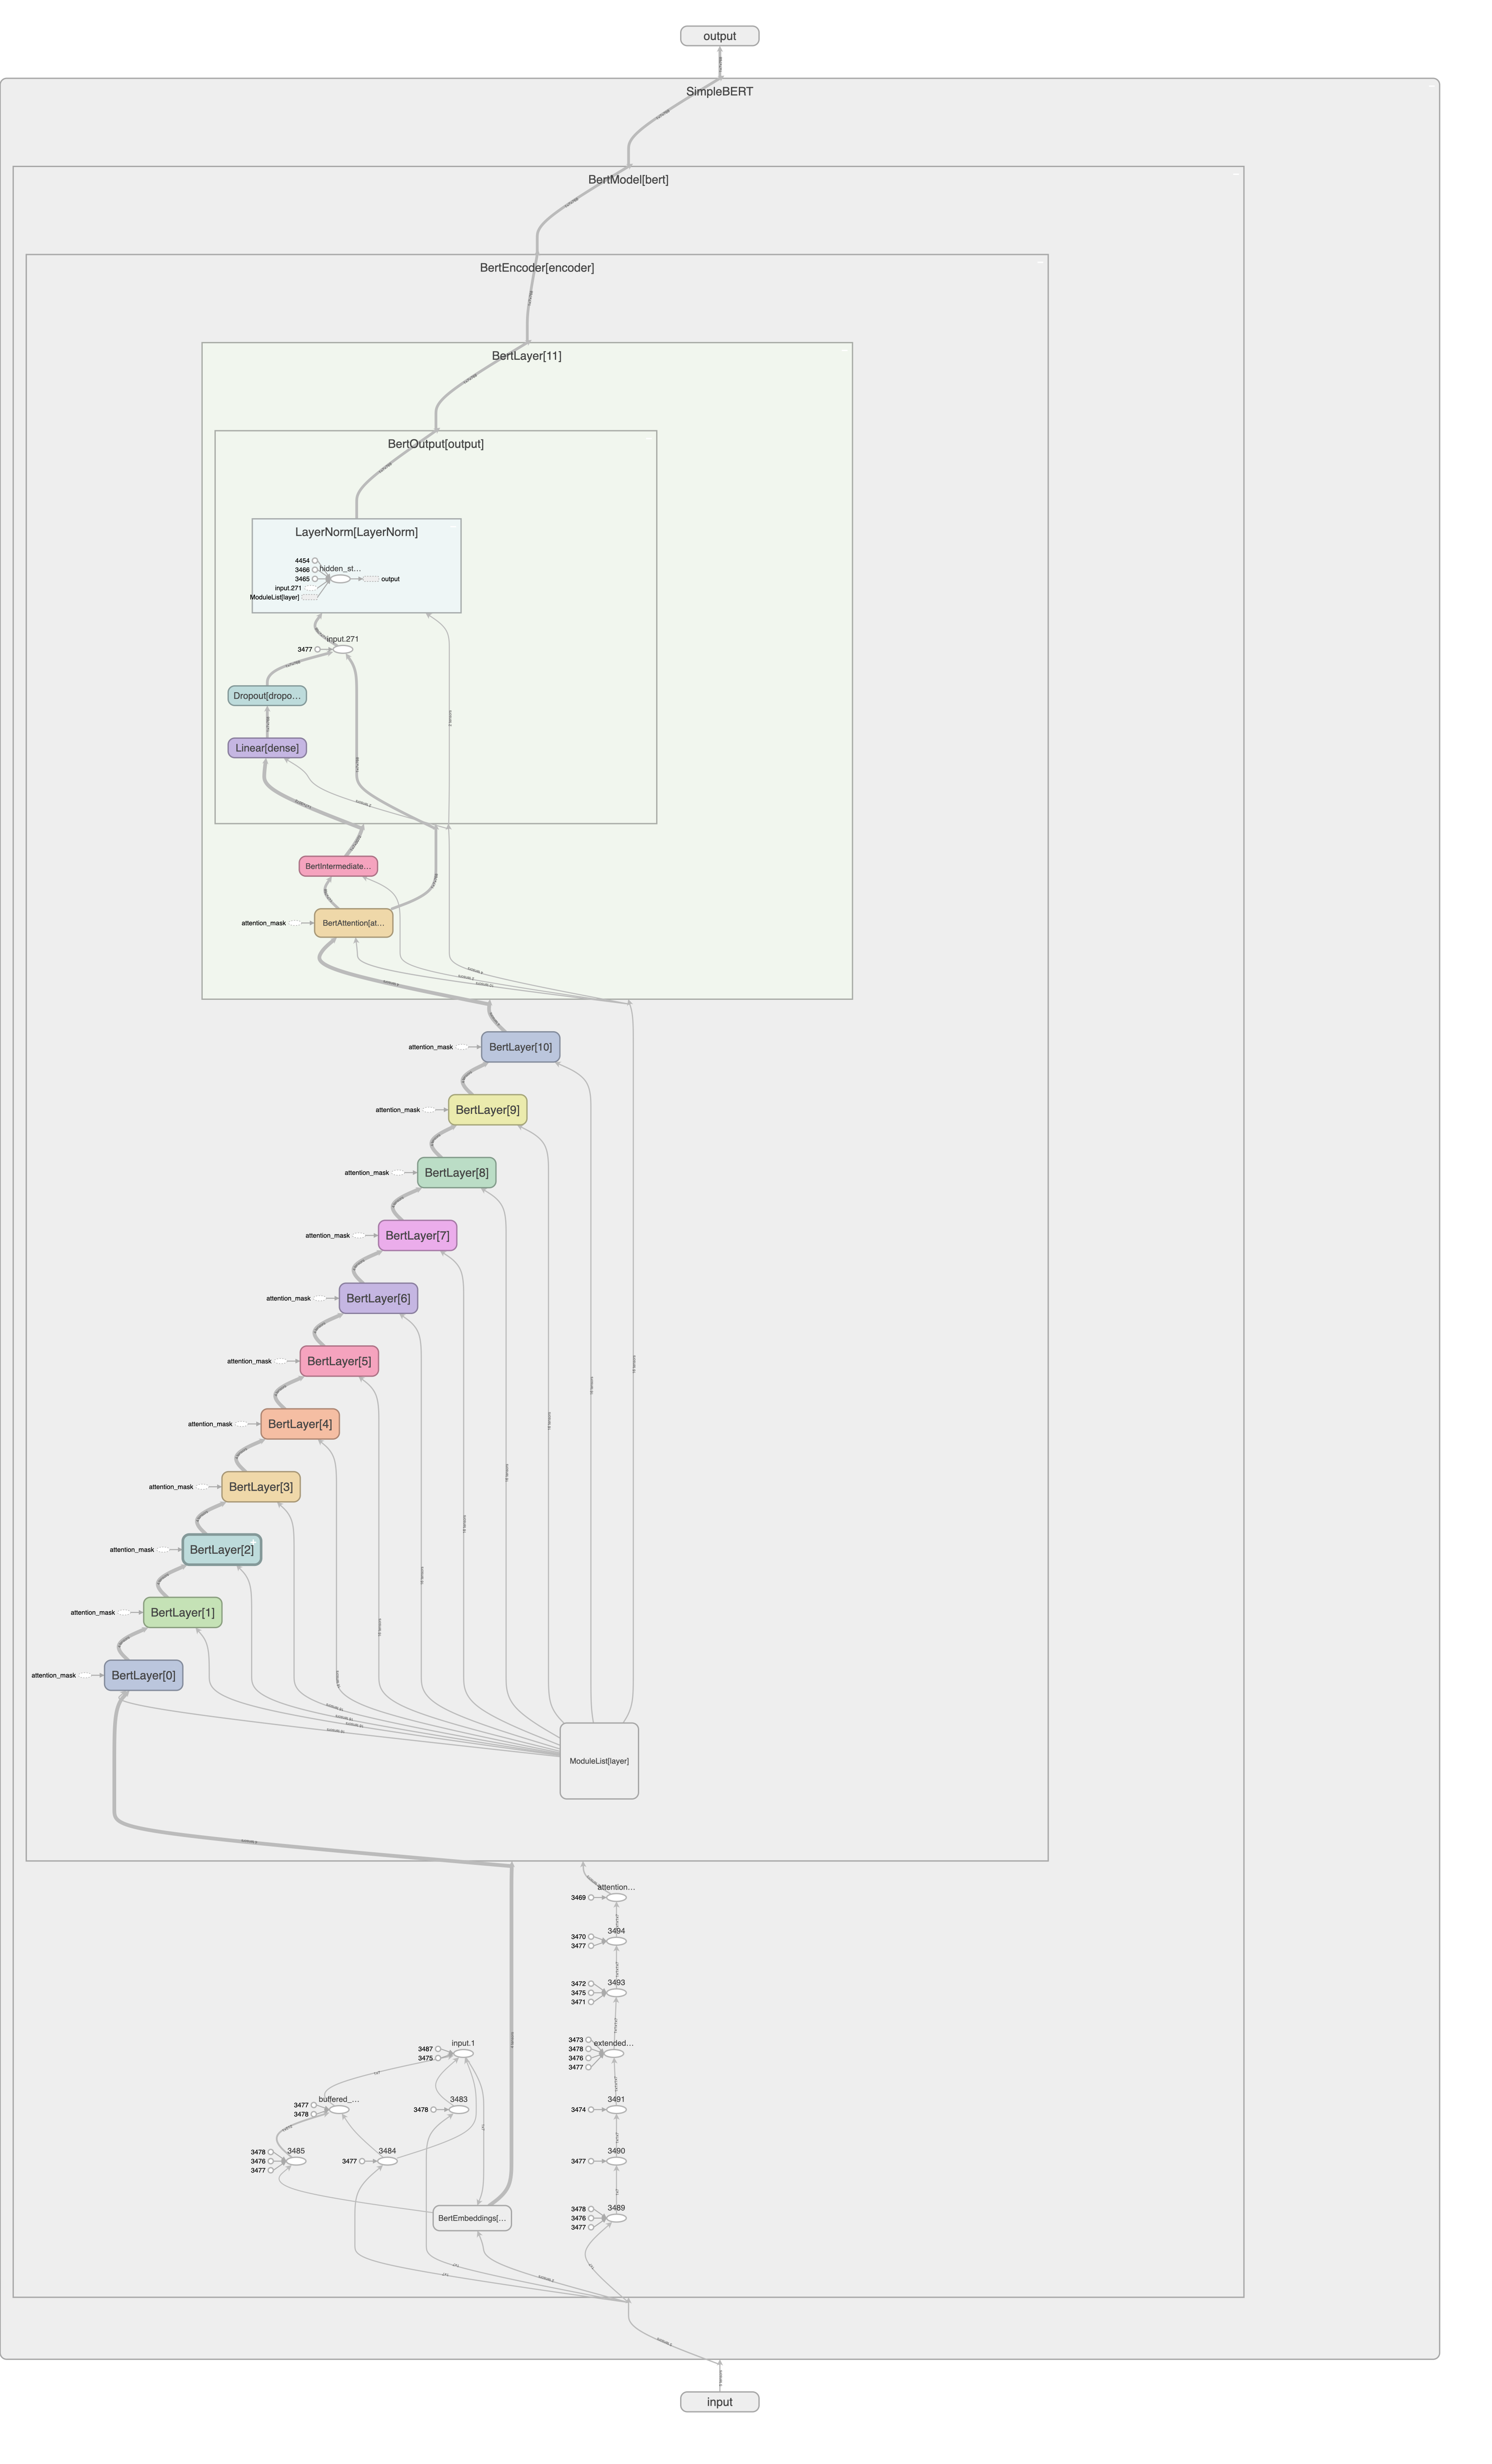

In [ ]:
import torchvision

### 역자 주: 이 코드 블록은 책의 16장의 마지막에 설명돼 있습니다.
images = torch.randn(32, 3, 64, 64) # 32개 이미지 배치 랜덤 생성
grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid, 0)


# Visualize Histogram

In [ ]:
for name, weight in model.named_parameters():
    writer.add_histogram(name, weight, epoch)

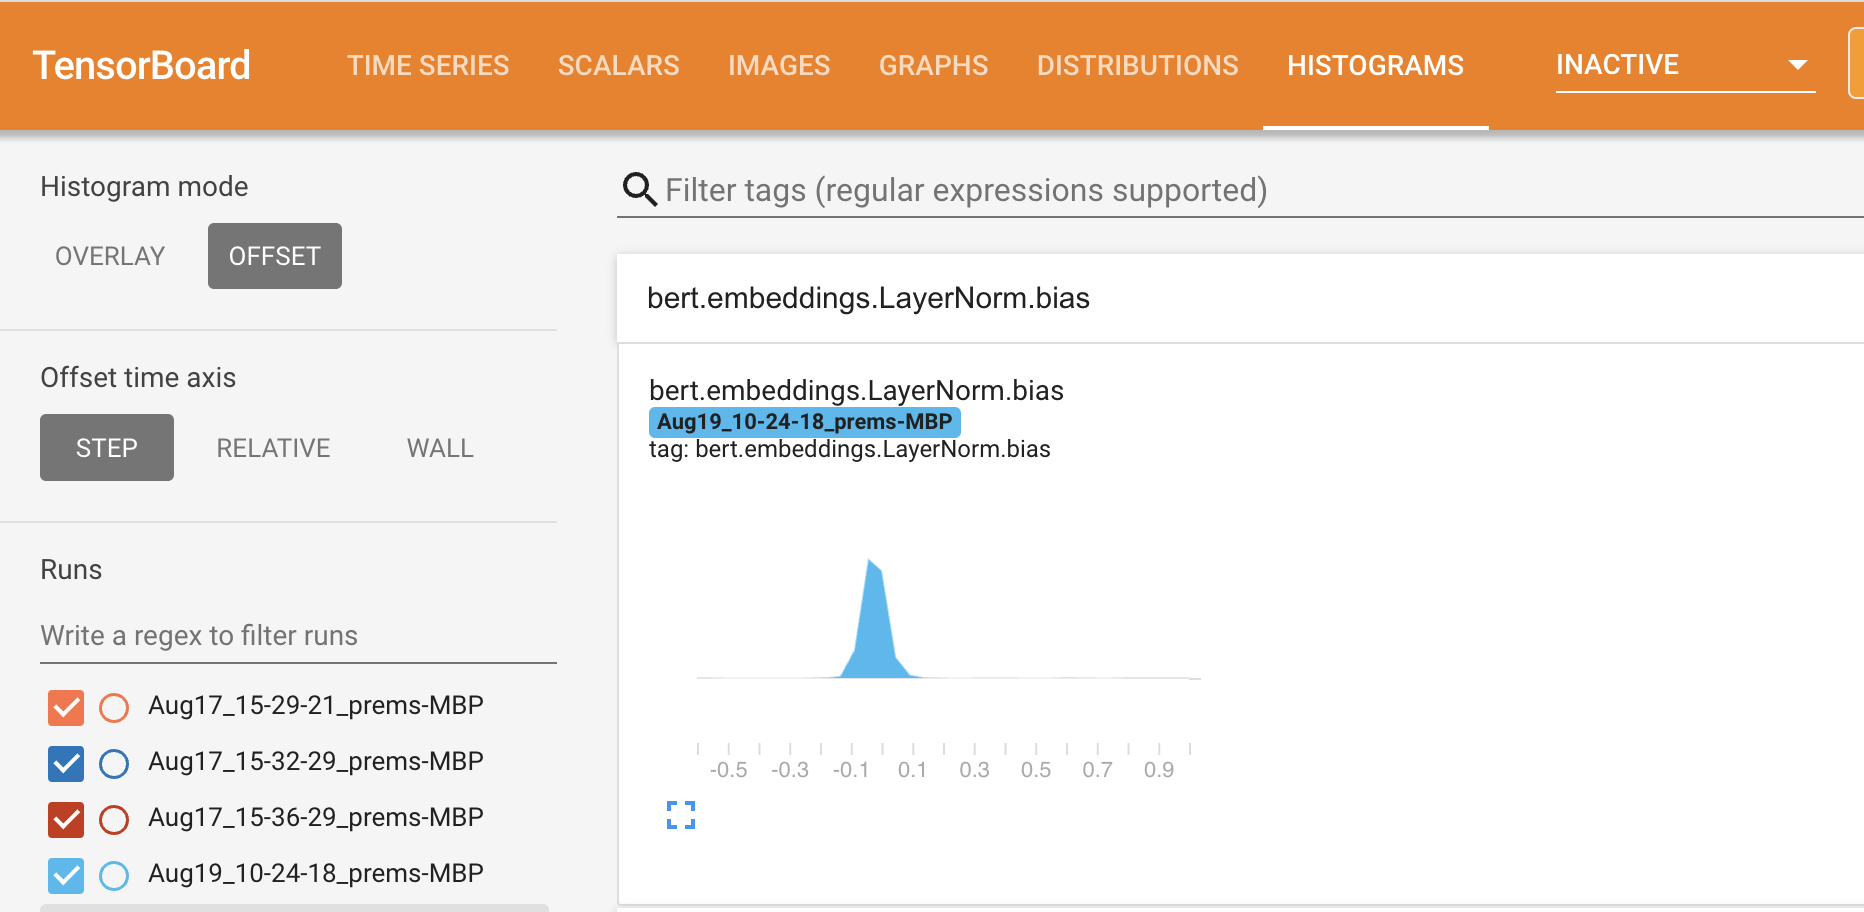

# Log Text

In [ ]:
writer.add_text('Loss_Text', 'The training loss was very low this epoch', epoch)


# Visualize Embedding

In [ ]:
import torch
from transformers import BertModel, BertTokenizer
from torch.utils.tensorboard import SummaryWriter

# 사전 학습 BERT 모델 및 토크나이저 불러내기
model_name = "bert-base-uncased"
bert_model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

class SimpleBERT(torch.nn.Module):
    def __init__(self, bert_model):
        super(SimpleBERT, self).__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state

model = SimpleBERT(bert_model)

# SummaryWriter 초기화
writer = SummaryWriter()

# BERT 모델용 더미 입력 생성
text = "I am fun and Happy"
tokens = tokenizer(text, return_tensors="pt")
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

### 역자 추가 코드: 16-5절 책에 나온 코드 추가
# TensorBoard에 BERT 모델 그래프 추가
writer.add_graph(model, [input_ids, attention_mask])

"""
# Close the writer
writer.close()
"""

# 모델을 사용하여 임베딩 추출
with torch.no_grad():
    embeddings = model(input_ids, attention_mask=attention_mask)

# 예를 들어, 토큰을 metadata로 사용
# Note: [CLS]와 [SEP] 토큰을 시각화를 위해 제거
metadata = [token for token in tokenizer.tokenize(text)]
embeddings = embeddings[0, 1:-1, :]  # [CLS]와 [SEP] 토큰 제거

writer.add_embedding(embeddings, metadata=metadata)

# writer 닫기
writer.close()


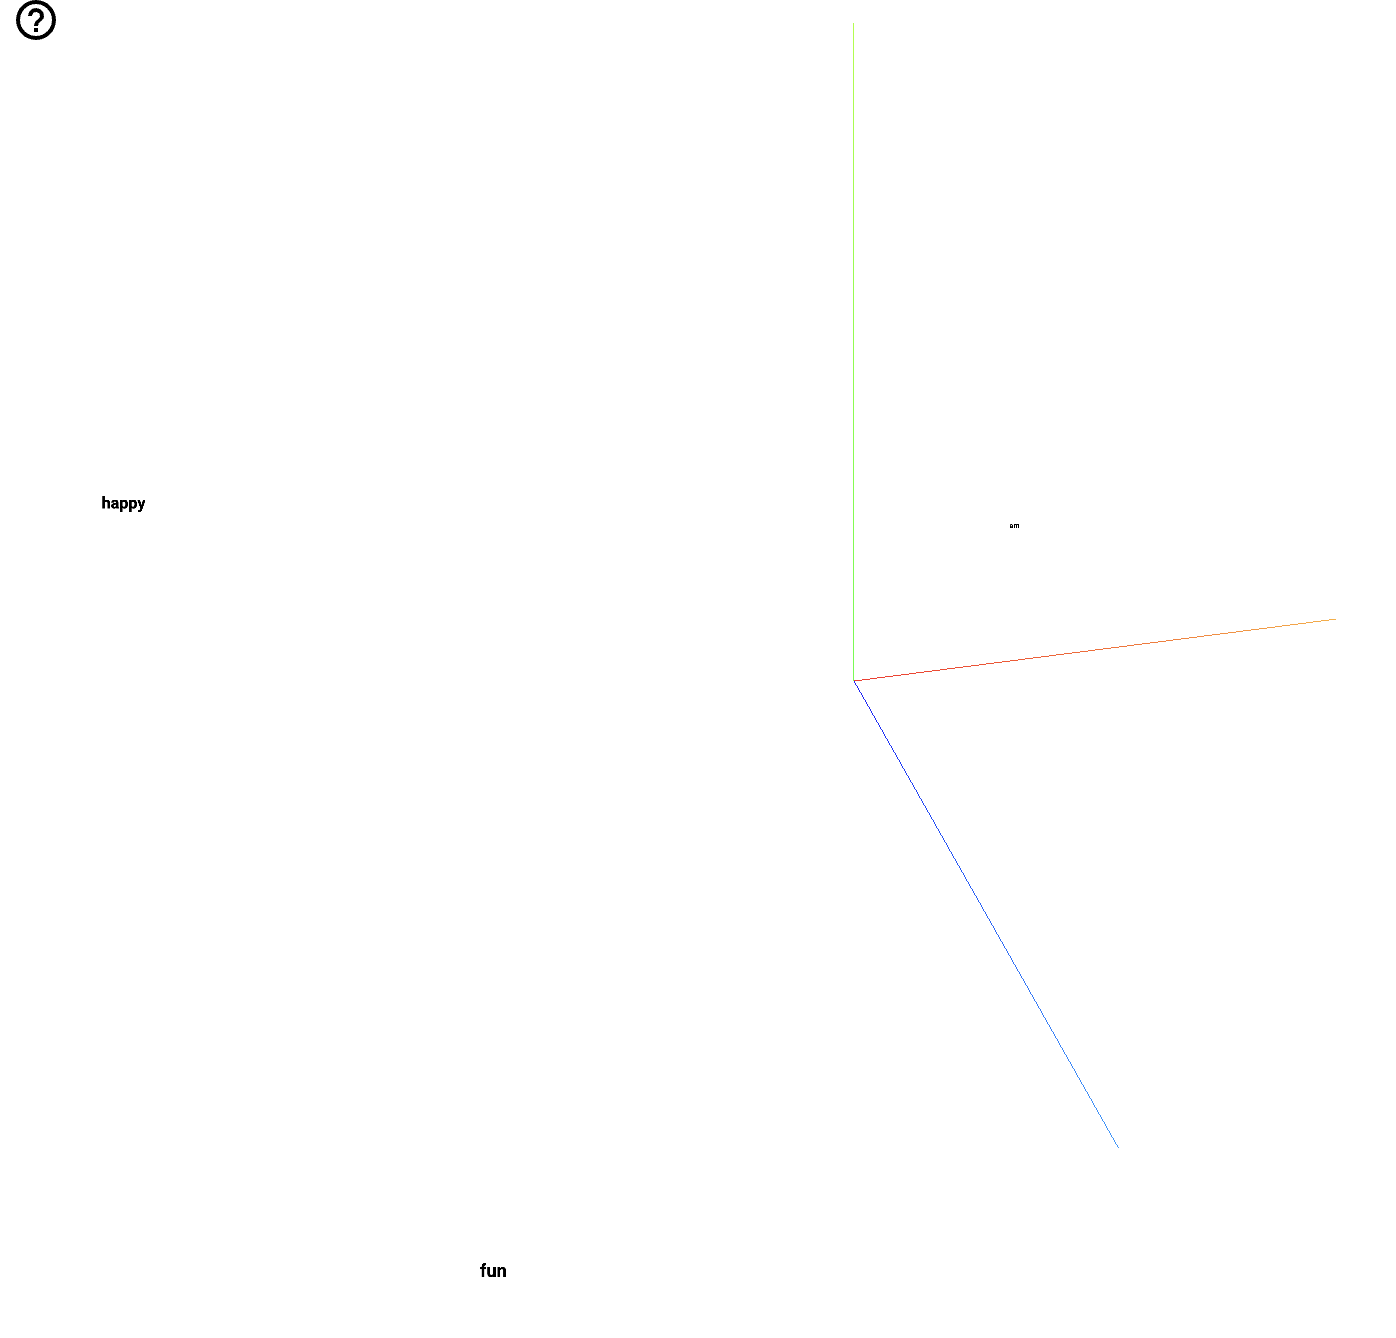

# Visualizing PR Curve

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

# Parameters
input_dim = 10
num_samples = 1000
batch_size = 32
num_epochs = 5

# Generate a dummy dataset
input_data = torch.randn(num_samples, input_dim)
# Create some dummy binary labels
true_labels = torch.randint(0, 2, (num_samples,)).float()

# Define a simple binary classification model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

model = SimpleModel()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# DataLoader
dataset = TensorDataset(input_data, true_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate TensorBoard writer
writer = SummaryWriter()

# Training loop
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # At the end of each epoch, compute probabilities for the entire dataset
    with torch.no_grad():
        probs = model(input_data).squeeze()
        writer.add_pr_curve('pr_curve', true_labels, probs, epoch)

# Close the writer
writer.close()


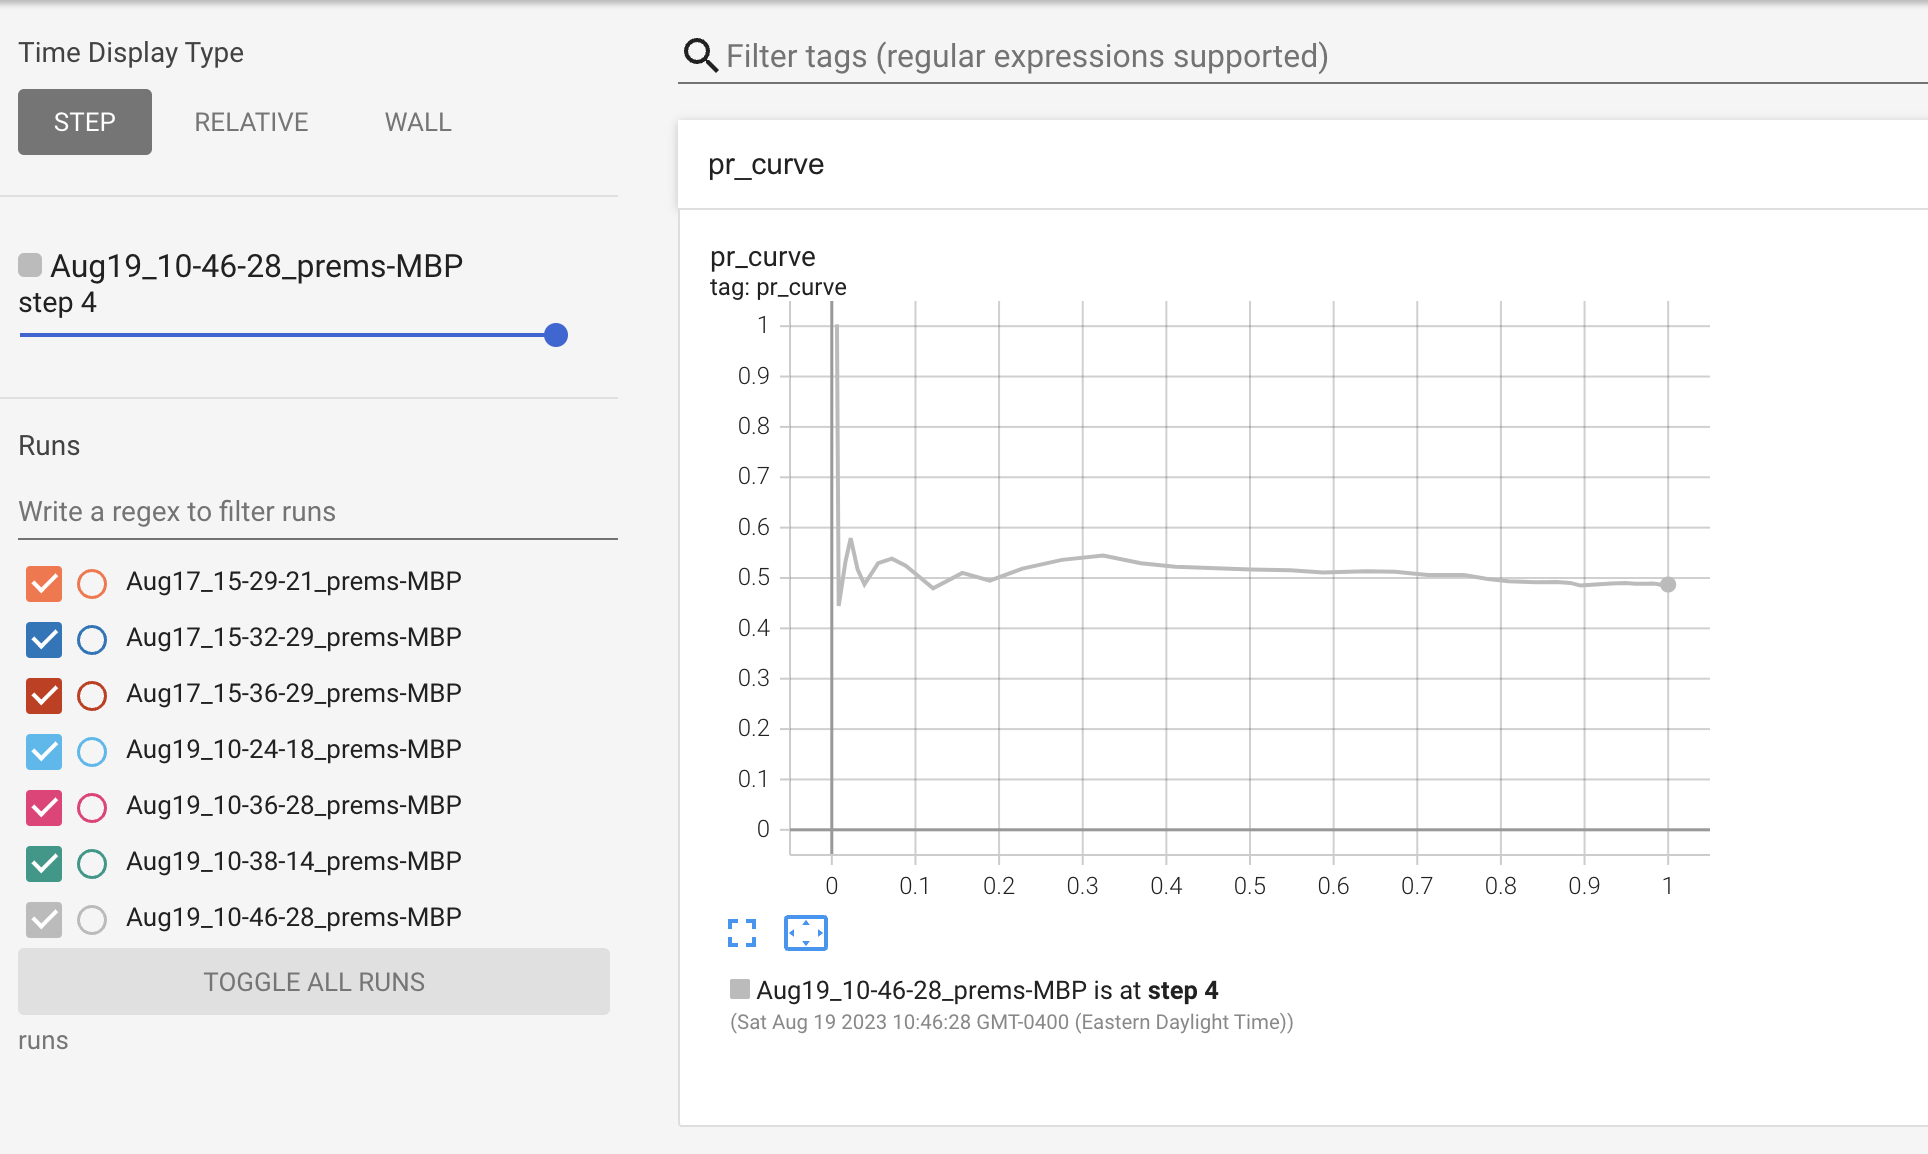

In [ ]:
### 역자 추가 코드: 16-5절 책에 나온 코드 추가
"""
hparams = {'lr': 0.1, 'batch_size': 32}
metrics = {'accuracy': 0.8}
writer.add_hparams(hparams, metrics)
"""

# Profiling

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

# Parameters
input_dim = 10
num_samples = 1000
batch_size = 32
num_epochs = 1

# Generate a dummy dataset
input_data = torch.randn(num_samples, input_dim)
# Create some dummy targets
targets = torch.randn(num_samples, 1)

# DataLoader
dataset = TensorDataset(input_data, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define a simple regression model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)

model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Instantiate TensorBoard writer
writer = SummaryWriter()

# Training step function
def train_step(inputs, targets):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop with profiling
for inputs, targets in dataloader:
    with torch.profiler.profile(with_stack=True) as prof:
        train_step(inputs, targets)

    # 프로파일링 결과를 텐서보드에 로깅(기록)
    writer.add_text("Profile", str(prof.key_averages().table()))

# writer 닫기
writer.close()


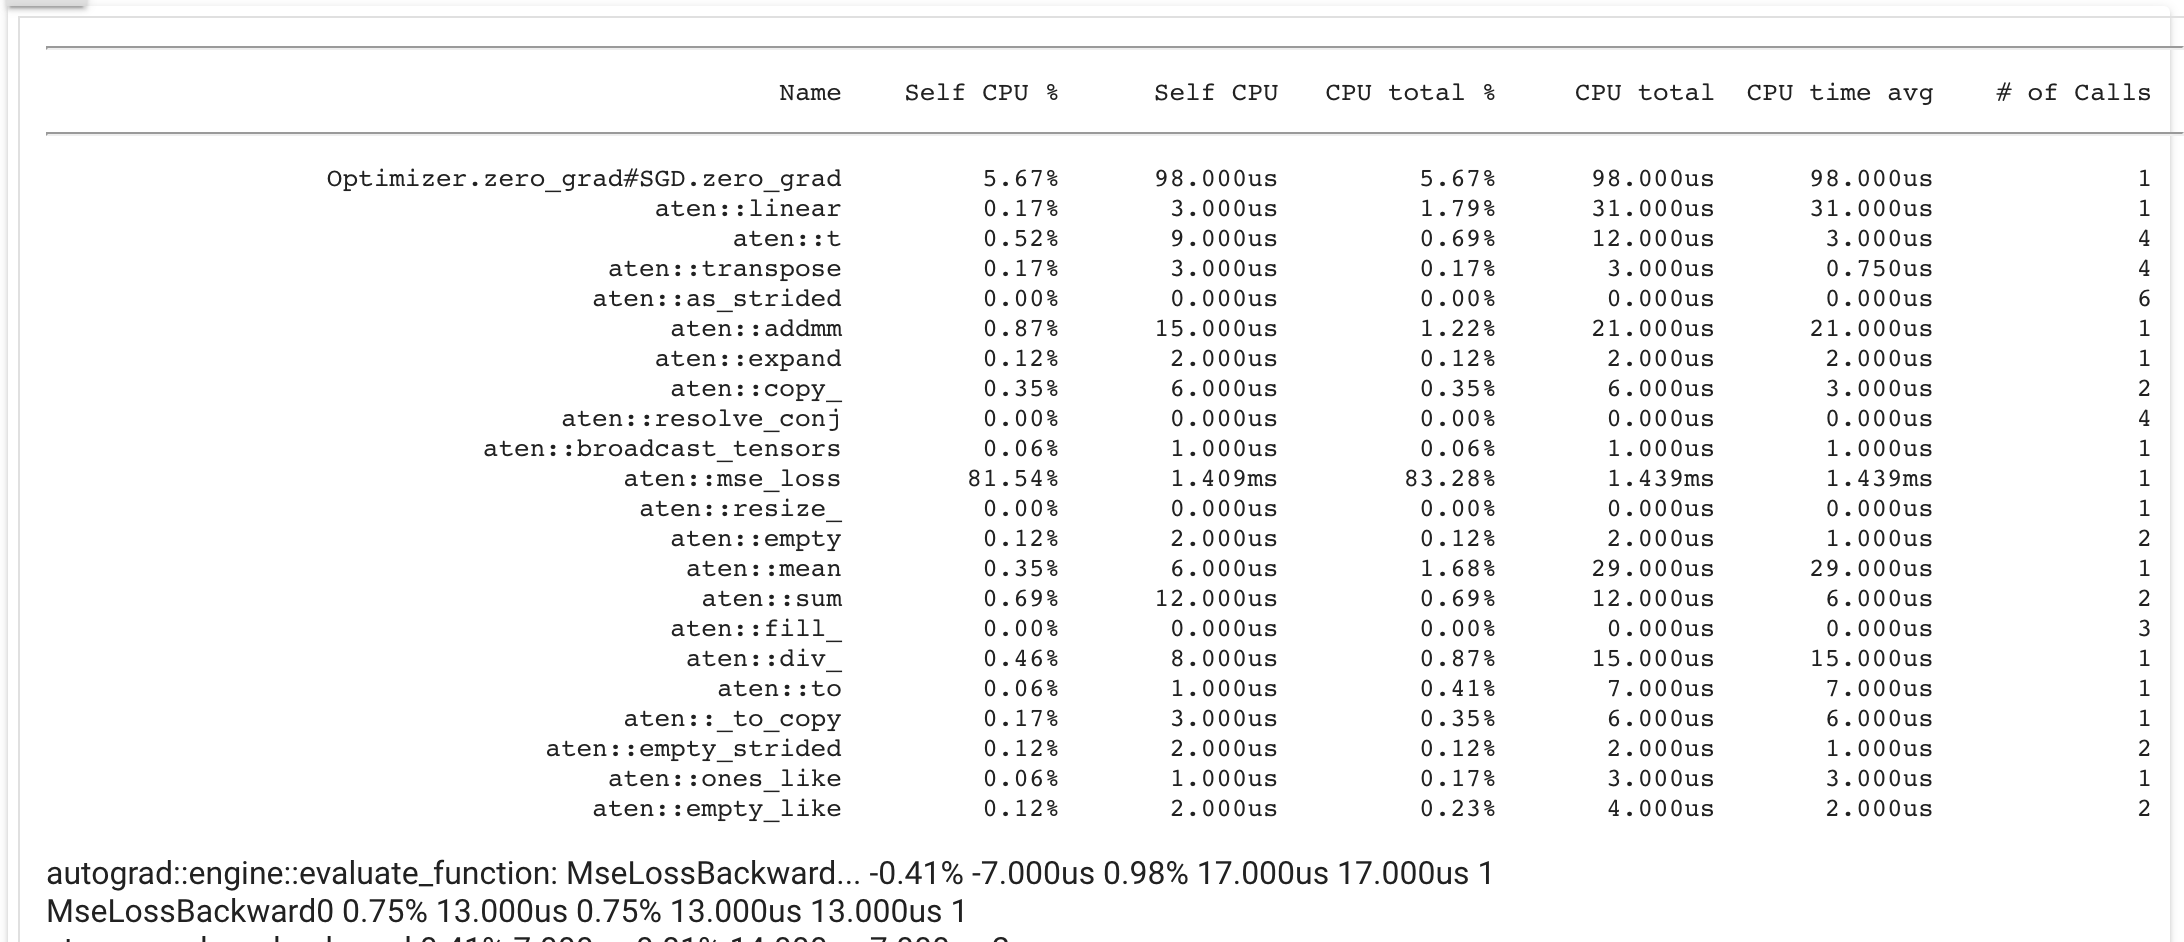